# 02 - Data from the Web

In this homework we will extract interesting information from [www.topuniversities.com](http://www.topuniversities.com) and [www.timeshighereducation.com](http://www.timeshighereducation.com), two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so we scrape the information we need. To understand how the server loads it in the browser, we used Postman with the Interceptor extension.

* [Task 1 - Scrape the QS ranking](#Task-1---Scrape-the-QS-ranking)
    * [Best universities for ratio between faculty memebers and students](#Which-are-the-best-universities-in-term-of-ratio-between-faculty-members-and-students-according-to-QS?)
    * [Best universities for the international students ratio](#Which-are-the-best-universities-in-term-of-ratio-of-international-students-according-to-QS?)
    * [Results by region](#Plot-the-results-from-QS-ranking-aggregating-by-region)
    * [Results by country](#Plot-the-results-from-QS-ranking-aggregating-by-country)


* [Task 2 - Scrape the Times ranking](#Task-2---Scrape-the-Times-ranking)
    * [Best universities for ratio between faculty memebers and students](#Which-are-the-best-universities-in-term-of-ratio-between-faculty-members-and-students-according-to-Times?)
    * [Best universities for the international students ratio](#Which-are-the-best-universities-in-term-of-ratio-of-international-students-according-to-Times?)
    * [Results by region](#Plot-the-results-from-Times-ranking-aggregating-by-region)
    * [Results by country](#Plot-the-results-from-Times-ranking-aggregating-by-country)
    
    
* [Task 3 - Merge the dataframes](#Task-3---Merge-the-dataframes)


* [Task 4 - Exploratory analysis](#Task-4---Exploratory-analysis)


* [Task 5 - Exploratory analysis](#Task-5--)

# Imports

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np
import string
import re
import pickle
import requests

pd.options.mode.chained_assignment = None
%matplotlib inline

# Constants definition

In [2]:
COLUMN_RANK = 'Rank'
COLUMN_UNIVERSITY_NAME = 'University Name'
COLUMN_REGION = 'Region'
COLUMN_COUNTRY = 'Country'
COLUMN_TOTAL_STUDENTS = 'Total Students'
COLUMN_INTERNATIONAL_STUDENTS = 'Total International Students'
COLUMN_TOTAL_FACULTY = 'Total Faculty'
COLUMN_INTERNATIONAL_FACULTY = 'Total International Faculty'
COLUMN_INTERNATIONAL_RATIO = 'Total International Students / Total Students'
COLUMN_FACULTY_RATIO = 'Total Faculty / Total Student'

In [3]:
QS_RANKING_JSON = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508104120137'
TIMES_RANKING_JSON = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [4]:
SEARCH_REFERENCE_API = 'https://en.wikipedia.org/w/api.php?action=query&titles={0}&prop=revisions&rvprop=content&format=json&indexpageids'

During the very first scraping of the QS ranking, we build a dataframe that contains the region for each country. This information will be used to fill in the region column in the Times dataframe.

After the first scraping is done, the three dataframes - containing the regions for each country and the two rankings - are serialized in local for future runs.

In [5]:
try:
    COUNTRY_REGION_METADATA = pd.read_pickle('serial/country_region_metadata.p')
except (OSError, IOError) as e:
    COUNTRY_REGION_METADATA = pd.DataFrame(columns=[COLUMN_REGION])
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')

Sample of the country-region dataframe:

In [6]:
COUNTRY_REGION_METADATA.head()

,Region
United States,North America
United Kingdom,Europe
Switzerland,Europe
Singapore,Asia
Australia,Oceania


# General use functions definition

We define some helper functions that will be used in the upcoming tasks.

In [7]:
def clean_str_number(str_n):
    """Obtain a string that only contains the numeric information, 
    dropping any formatting character.
    
    str_n -- a string containg both numeric and formatting characters
    
    return a string only with numeric characters
    """
    
    return str_n.strip('\n').strip('%').replace(',', '')

In [8]:
def search_standard_name(str_name):
    """Given a name, query the WikiData database to obtain the WikiData formatted entry.
    The function takes care of cleaning up the string in order to ease
    the research process.
    
    str_name -- the query to search in the WikiData
    
    return the WikiData formatted entry of the query value if found,
    the cleaned up version of the passed value otherwise
    """
    
    str_name = str_name.split(" - ")[0] # Manage name with - (short)
    str_name = str_name.split(" – ")[0] # Manage name with – (long)
    str_name = re.sub('\(.*?\)','', str_name) # no brackets
    str_name = str_name.strip().replace('&', '%26')
    
    r = requests.get(SEARCH_REFERENCE_API.format(str_name.strip().replace(' ', '_')))
    data = r.json()
    
    page_id = data['query']['pageids'][0]
    
    if (page_id == '-1'):
        print('Not found :( -> {}'.format(str_name))
        
        # Manually set a standard name for the only unmatchable university. 
        # We have a total of 9 unknown sources during the WikiData requests, but only one university appears twice
        # and it need to receive a standard name to be merged later on. The other onces could keep their name
        if (str_name == "Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento"):
            found_name = "Scuola Superiore Sant’Anna"
        else:
            found_name = str_name
    else:
        found_name = data['query']['pages'][page_id]['title']
        
    return(found_name)

In [9]:
def update_country_region_metadata(country, region):
    """Append a new entry to the global dataframe that relates regions and countries.
    
    country -- the country to add
    region -- the region to add
    """
    
    global COUNTRY_REGION_METADATA
    
    if (country in COUNTRY_REGION_METADATA.index):
        return
    
    new_row = pd.Series(region, index=[COLUMN_REGION])
    new_row.name = country
    
    COUNTRY_REGION_METADATA = COUNTRY_REGION_METADATA.append(new_row)

# Task 1 - Scrape the QS ranking
This task consists on obtaining the 200 top-ranking universities in www.topuniversities.com (ranking 2018). We define the function `scrape_qs_ranking`. Since some of the information is missing from the main page, we need to scrape the remaining data from the details pages for each of the universities in the ranking - this is done using the `parse_detail_page` function.

In [10]:
def parse_detail_page(url_detail):
    """Parses information from the detail page of the university from the QS website.

    url_detail -- the url of the detail page to scrape

    Return a dictionary with all the data found as integers values
    """
    
    # Build a parser for the detail page
    soup = BeautifulSoup(requests.get(url_detail).text, 'html.parser')
    
    # Obtain and clean up the total faculty member value
    try:
        faculty_member_total = soup.find('div', class_='total faculty').find('div', class_='number').text
        faculty_member_total = clean_str_number(faculty_member_total)
    except AttributeError:
        faculty_member_total = -1
    
    
    # Obtain and clean up the international faculty member value
    try:
        faculty_member_inter = soup.find('div', class_='inter faculty').find('div', class_='number').text.strip('\n')
        faculty_member_inter = clean_str_number(faculty_member_inter)
    except AttributeError:
        faculty_member_inter = -1
    
    # Obtain and clean up the total students value
    try:
        student_total = soup.find('div', class_='total student').find('div', class_='number').text.strip('\n')
        student_total = clean_str_number(student_total)
    except AttributeError:
        student_total = -1
    
    # Obtain and clean up the international students value
    try:
        student_inter = soup.find('div', class_='total inter').find('div', class_='number').text.strip('\n')
        student_inter = clean_str_number(student_inter)
    except AttributeError:
        student_inter = -1
    
    # Build a dictionary for the parsed informations
    detail_info = {COLUMN_TOTAL_FACULTY: int(faculty_member_total), 
                   COLUMN_INTERNATIONAL_FACULTY: int(faculty_member_inter), 
                   COLUMN_TOTAL_STUDENTS: int(student_total), 
                   COLUMN_INTERNATIONAL_STUDENTS: int(student_inter)
                  }
    
    return detail_info

After some work on the Postman Inspector, we found out that the GET Request made to the QS website ended up with multiple attached files to go with the response. One of those files was a JSON with all the infos from the ranking.

In [11]:
req = requests.get(QS_RANKING_JSON)
data_from_url = req.json()

Such data is stored as a list of dictionaries, as visible in the example below:

In [12]:
print('First cell:')
print(data_from_url['data'][0], end='\n\n')

print('Second cell:')
print(data_from_url['data'][1], end='\n\n')

print('...')

First cell:
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}

Second cell:
{'nid': '297282', 'url': '/universities/stanford-university', 'title': 'Stanford University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/stanford-university_573_small_0.jpg" alt="Stanford University Logo">', 'core_id': '573', 'score': '98.7', 'rank_display': '2', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a h

We extract all the information from both the ranking webpage and the details webpage for each university.

There are some universities that have a tie in their positions in the ranking, but we are assuming that there are no ties and that the universities are ordered according to their position in the ranking.

In [13]:
def scrape_qs_ranking():
    """Obtain the ranking from the top 200 of QS in a dataframe
    
    return the dataframe containing all the informations (main and detail page) of QS ranking
    """
    
    data = requests.get(QS_RANKING_JSON).json()
    university_list = []

    # Iterate through the first 200 universities in the list
    for i, d in enumerate(data['data'][:200]):
    
        # Store the parsed information into a dictionary
        info = {COLUMN_RANK: (i+1),
                COLUMN_UNIVERSITY_NAME: search_standard_name(d['title']),
                COLUMN_COUNTRY: d['country'],
                COLUMN_REGION: d['region']
               }
        
        # Update country-region dataframe if there is new information
        update_country_region_metadata(d['country'], d['region'])
    
        # Extend the dictionary with the informations in the detail page
        url_detail = 'https://www.topuniversities.com' +  d['url']
        info.update(parse_detail_page(url_detail))
        
        # Appending university entry
        university_list.append(info)
    
    # After scraping data from QS ranking the metadata dataframe needs to be stored updated
    COUNTRY_REGION_METADATA.to_pickle('serial/country_region_metadata.p')
    
    qs_ranking_df = pd.DataFrame.from_dict(university_list)
    return qs_ranking_df

After defining the functions we need, we scrape the webpage and serialize the dataframe. If the serialized object already exists, we deserialize it and do not scrape the page again. 

In [14]:
try:
    qs_ranking_df = pd.read_pickle('serial/qs_save.p')
except (OSError, IOError) as e:
    qs_ranking_df = scrape_qs_ranking()
    qs_ranking_df.to_pickle('serial/qs_save.p')
    
qs_ranking_df.head()

,Country,Rank,Region,Total Faculty,Total International Faculty,Total International Students,Total Students,University Name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University
3,United States,4,North America,953,350,647,2255,California Institute of Technology
4,United Kingdom,5,Europe,5490,2278,6699,18770,University of Cambridge


Lastly, we set a meaningful unique index.

In [15]:
qs_ranking_df.set_index(COLUMN_UNIVERSITY_NAME, inplace=True)

### Which are the best universities in terms of ratio between faculty members and students according to QS?

In [16]:
# Compute the ratio between faculty member and students
qs_ranking_df[COLUMN_FACULTY_RATIO] = qs_ranking_df[COLUMN_TOTAL_FACULTY] / qs_ranking_df[COLUMN_TOTAL_STUDENTS]

# Clean up the computation taking care of unknown values (previously set at -1)
qs_fsratio_defined = (qs_ranking_df[COLUMN_TOTAL_FACULTY] != -1) | (qs_ranking_df[COLUMN_TOTAL_STUDENTS] != -1)
qs_ranking_df.loc[~qs_fsratio_defined, COLUMN_FACULTY_RATIO] = float('nan')

# Define a dataset for the result computation
qs_faculty_students_rank_df = qs_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_TOTAL_FACULTY,
                                             COLUMN_TOTAL_STUDENTS, COLUMN_FACULTY_RATIO]]
qs_faculty_students_rank_df = qs_faculty_students_rank_df.sort_values(COLUMN_FACULTY_RATIO, ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

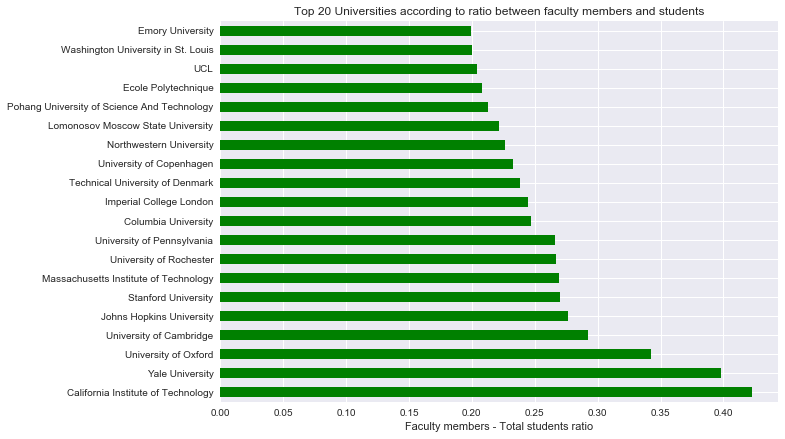

In [17]:
qs_faculty_students_rank_df[:20][COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,7), color='green')

plt.title('Top 20 Universities according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

It is interesting to note that the top three universities in this particular ranking have a ratio considerably higher than the other universities'. For the rest of the universities the value of the ratio decreases, but slower.

### Which are the best universities in terms of ratio of international students according to QS?

In [18]:
# Compute the ratio of international students
qs_ranking_df[COLUMN_INTERNATIONAL_RATIO] = qs_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] / qs_ranking_df[COLUMN_TOTAL_STUDENTS]

# Clean up the computation taking care of unknown values (previously set at -1)
qs_isratio_defined = (qs_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] != -1) | (qs_ranking_df[COLUMN_TOTAL_STUDENTS] != -1)
qs_ranking_df.loc[~qs_isratio_defined, COLUMN_INTERNATIONAL_RATIO] = float('nan')

# Define a dataset for the result computation
qs_international_students_rank_df = qs_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_INTERNATIONAL_STUDENTS,
                                                   COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_RATIO]]
qs_international_students_rank_df = qs_international_students_rank_df.sort_values(COLUMN_INTERNATIONAL_RATIO,
                                                                                  ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

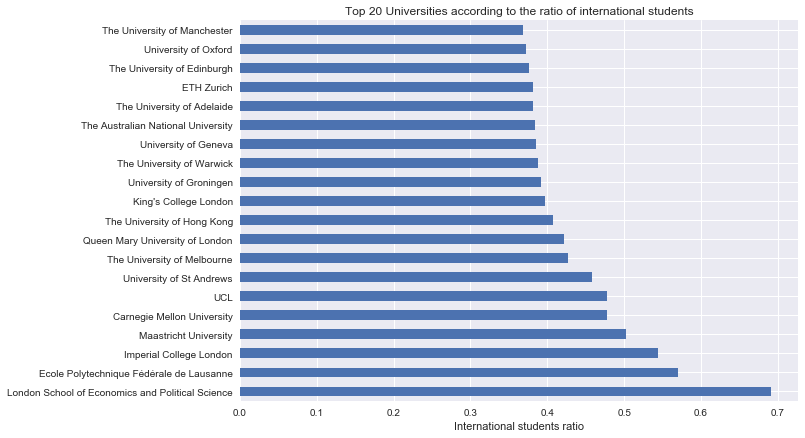

In [19]:
qs_international_students_rank_df[:20][COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10,7))

plt.title('Top 20 Universities according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

In this case we can see from the plot that *London School of Economics and Political Science* has a very high ratio of international students, followed by EPFL. In this case, the universities in the second half of the ranking have a very similar ratio of international students.

### Plot the results from QS ranking aggregating by region

For this question, we looked at the university with the best ratio in each region, for each of our defined ratios.

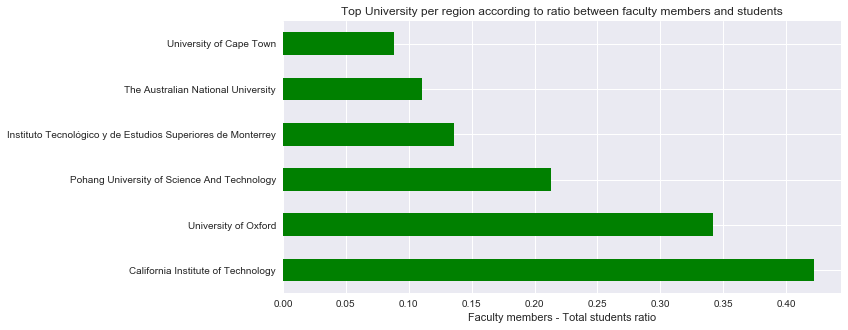

In [20]:
qs_faculty_student_ratio_by_region_df = qs_faculty_students_rank_df.groupby(COLUMN_REGION).head(1)
qs_faculty_student_ratio_by_region_df[COLUMN_FACULTY_RATIO].plot(kind='barh',figsize=(10,5),  color='green')

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

Then, for the international students' ratio:

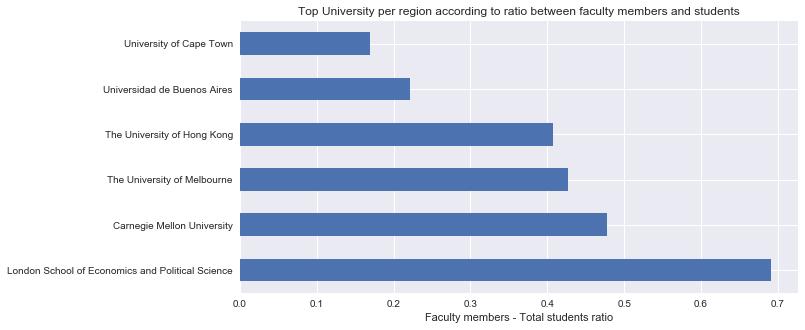

In [21]:
qs_international_students_ratio_by_region_df = qs_international_students_rank_df.groupby(COLUMN_REGION).head(1)
qs_international_students_ratio_by_region_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10,5))

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

### Plot the results from QS ranking aggregating by country

For this question, we plotted the universities with the highest values for each of the previously calculated ratios.

First for the faculty to student ratio:

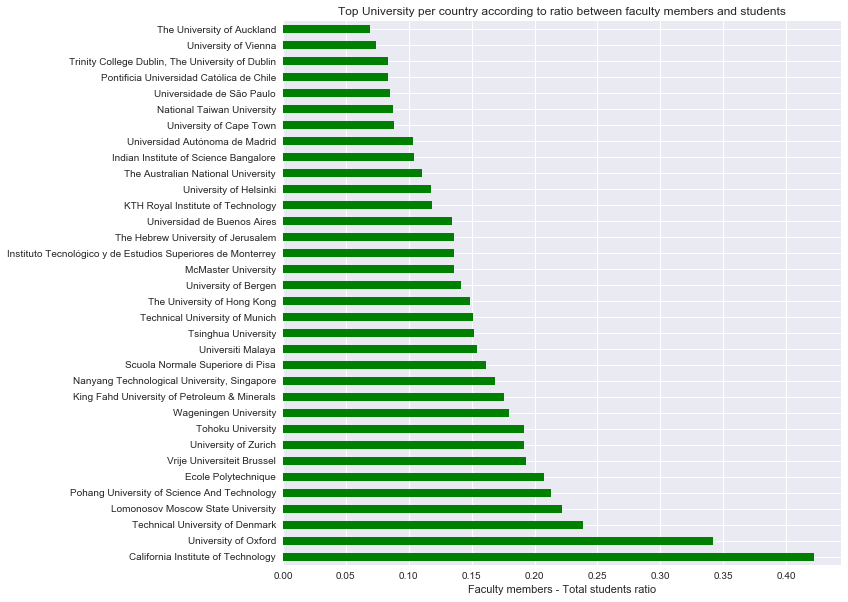

In [22]:
qs_faculty_student_ratio_by_country_df = qs_faculty_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
qs_faculty_student_ratio_by_country_df[COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,10), color='green')

plt.title('Top University per country according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

And then for the international students' ratio:

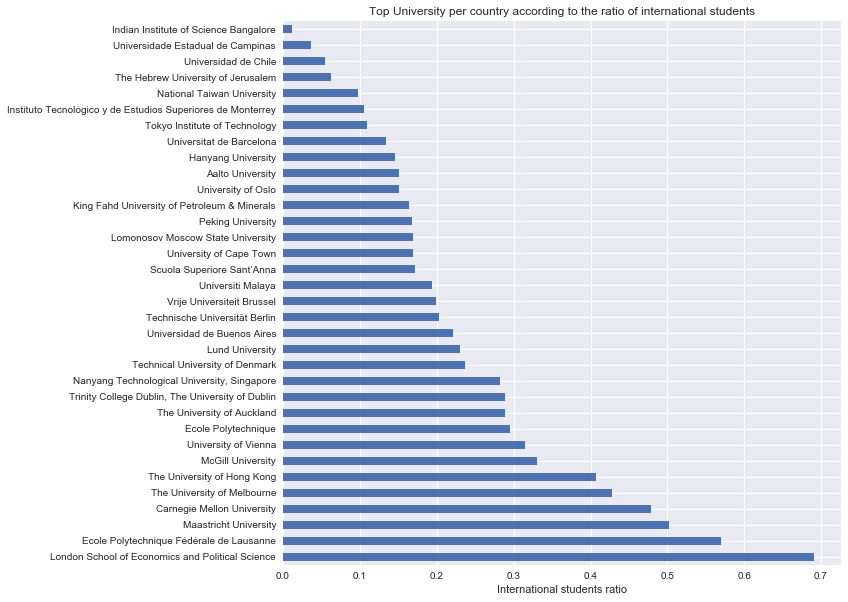

In [23]:
qs_international_students_ratio_by_country_df = qs_international_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
qs_international_students_ratio_by_country_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per country according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

# Task 2 - Scrape the Times ranking
We now obtain the 200 top-ranking universities in [www.timeshighereducation.com](http://www.timeshighereducation.com) (ranking 2018), and repeat the analysis of the previous point.

First, we define the auxiliary functions that we will need later on.

In [24]:
def compute_value_from_percentage(total, percentage):
    """Function that returns a value, calculated as a percentage of the given 'total'.
    
    total -- the value corresponding to 100%
    percentage -- the desired percentage of the total
    
    return the calculated value
    """
    
    total = int(total)
    percentage = float(percentage)
    
    return round((total/100) * percentage)

In [25]:
def compute_value_from_proportion(total, proportion):
    """Function to compute the proportion of a given total.
    
    total -- the value on which to calculate the percentage
    proportion -- the proportion value
    
    return the calculated value
    """
    
    total = int(total)
    proportion = float(proportion)
    
    return round(total / proportion)

In [26]:
def scrape_times_ranking():
    """Obtain the ranking from the top 200 of Times in a dataframe.
    
    return the dataframe containing all the informations of Times ranking
    """

    data = requests.get(TIMES_RANKING_JSON).json()
    university_list = []

    # Iterate through the first 200 universities in the ranking
    for i, d in enumerate(data['data'][:200]):
        
        # Preliminary computations to extract data
        intern_student = compute_value_from_percentage(clean_str_number(d['stats_number_students']), 
                                                       clean_str_number(d['stats_pc_intl_students'])
                                                      )
    
        faculty_member_total = compute_value_from_proportion(clean_str_number(d['stats_number_students']), 
                                                             clean_str_number(d['stats_student_staff_ratio'])
                                                            )
        
        # Determine region from the data of the QS ranking stored in the metadata
        try:
            region = COUNTRY_REGION_METADATA.get_value(d['location'], 'Region')
        except KeyError:
            region = 'NaN'
    
        # Store the parsed information into a dictionary
        info = {COLUMN_RANK: (i+1), 
                COLUMN_UNIVERSITY_NAME: search_standard_name(d['name']), 
                COLUMN_COUNTRY: d['location'],
                COLUMN_REGION: region,
                COLUMN_TOTAL_STUDENTS: int(clean_str_number(d['stats_number_students'])),
                COLUMN_INTERNATIONAL_STUDENTS: int(intern_student),
                COLUMN_TOTAL_FACULTY: int(faculty_member_total)
               }
    
        university_list.append(info)
   
    times_ranking_df = pd.DataFrame.from_dict(university_list)
    return times_ranking_df

After defining the functions we need, we scrape the webpage and serialize the dataframe. If the serialized object already exists, we deserialize it and do not scrape the page again. 

In [27]:
try:
    times_ranking_df = pd.read_pickle('serial/times_save.p')
except (OSError, IOError) as e:
    times_ranking_df = scrape_times_ranking()
    times_ranking_df.to_pickle('serial/times_save.p')
    
times_ranking_df.head()

,Country,Rank,Region,Total Faculty,Total International Students,Total Students,University Name
0,United Kingdom,1,Europe,1822,7755,20409,University of Oxford
1,United Kingdom,2,Europe,1687,6436,18389,University of Cambridge
2,United States,3,North America,340,596,2209,California Institute of Technology
3,United States,4,North America,2113,3486,15845,Stanford University
4,United States,5,North America,1285,3800,11177,Massachusetts Institute of Technology


We then set a meaningful unique index.

In [28]:
times_ranking_df.set_index(COLUMN_UNIVERSITY_NAME, inplace=True)

Even after extrapolating the region information from the first dataset, we might have some missing data. Those will be manually handled to completely fill in the table.

In [29]:
times_ranking_df[times_ranking_df[COLUMN_REGION] == 'NaN']

,Country,Rank,Region,Total Faculty,Total International Students,Total Students
University Name,,,,,,
University of Luxembourg,Luxembourg,179,NaN,340,2832,4969
Lomonosov Moscow State University,Russian Federation,194,NaN,4005,6432,29236


In [30]:
# Manually fix the missing data
times_ranking_df.set_value('University of Luxembourg', COLUMN_REGION, 'Europe')
times_ranking_df.set_value('Lomonosov Moscow State University', COLUMN_REGION, 'Europe')

# Verification
times_ranking_df[times_ranking_df[COLUMN_COUNTRY] == 'Luxembourg']

,Country,Rank,Region,Total Faculty,Total International Students,Total Students
University Name,,,,,,
University of Luxembourg,Luxembourg,179,Europe,340,2832,4969


### Which are the best universities in terms of ratio between faculty members and students according to Times?

In [31]:
# Compute the ratio between faculty member and students
times_ranking_df[COLUMN_FACULTY_RATIO] = (times_ranking_df[COLUMN_TOTAL_FACULTY] /
                                          times_ranking_df[COLUMN_TOTAL_STUDENTS])

# Clean up the computation, taking care of unknown values (previously set at -1)
times_isratio_defined = ((times_ranking_df[COLUMN_TOTAL_FACULTY] != -1) |
                         (times_ranking_df[COLUMN_TOTAL_STUDENTS] != -1))
times_ranking_df.loc[~times_isratio_defined, COLUMN_FACULTY_RATIO] = float('nan')

# Define a dataset for the result computation
times_faculty_students_rank_df = times_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_TOTAL_FACULTY,
                                                   COLUMN_TOTAL_STUDENTS, COLUMN_FACULTY_RATIO]]
times_faculty_students_rank_df = times_faculty_students_rank_df.sort_values(COLUMN_FACULTY_RATIO,
                                                                            ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

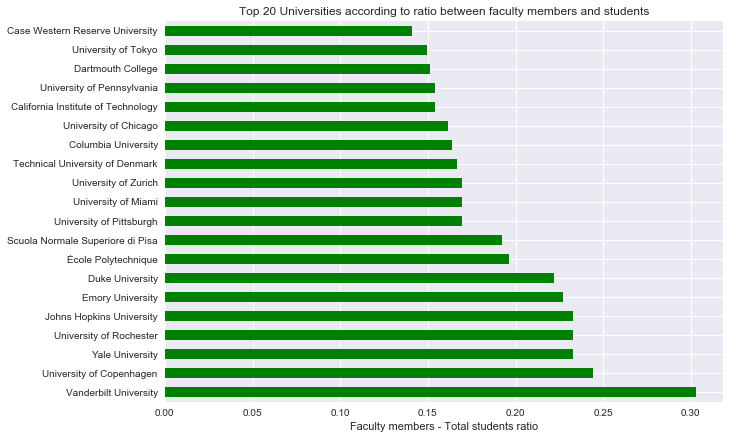

In [32]:
times_faculty_students_rank_df[:20][COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,7), color='green')

plt.title('Top 20 Universities according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

In this ranking, there are two groups of universities with very similar values for their *faculty to students* ratio. This is different from the previous plot for the QS ranking, where the decrease in the ratio value was more gradual.

### Which are the best universities in terms of ratio of international students according to Times?

In [33]:
# Compute the ratio of international students
times_ranking_df[COLUMN_INTERNATIONAL_RATIO] = (times_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] /
                                                times_ranking_df[COLUMN_TOTAL_STUDENTS])

# Clean up the computation taking care of unknown values (previously set at -1)
times_isratio_defined = ((times_ranking_df[COLUMN_INTERNATIONAL_STUDENTS] != -1) |
                         (times_ranking_df[COLUMN_TOTAL_STUDENTS] != -1))
times_ranking_df.loc[~times_isratio_defined, COLUMN_INTERNATIONAL_RATIO] = float('nan')

# Define a dataset for the result computation
times_international_students_rank_df = times_ranking_df[[COLUMN_COUNTRY, COLUMN_REGION, COLUMN_INTERNATIONAL_STUDENTS,
                                                         COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_RATIO]]
times_international_students_rank_df = times_international_students_rank_df.sort_values(COLUMN_INTERNATIONAL_RATIO,
                                                                                        ascending=False)

After computing the ratio, we plot it for the 20 universities with the highest values:

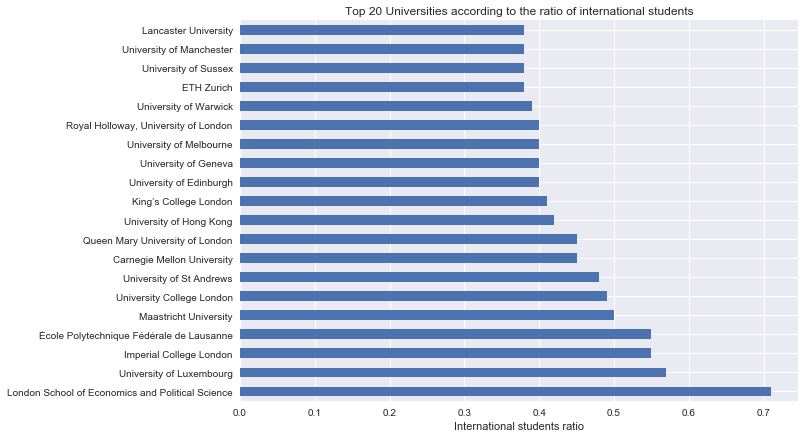

In [34]:
times_international_students_rank_df[:20][COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10,7))

plt.title('Top 20 Universities according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

This plot is very similar to the one for the QS ranking, regarding the fact that the universities in the second half of the ranking have a very similar ratio of international students.

### Plot the results from Times ranking aggregating by region

For this question, we looked at the university with the best ratio in each region, for each of our defined ratios.

For the faculty to student ratio:

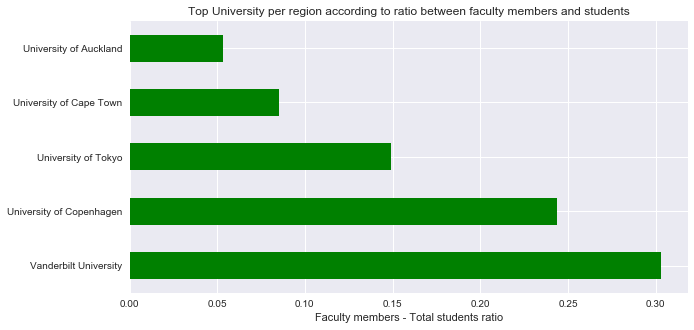

In [35]:
times_faculty_student_ratio_by_region_df = times_faculty_students_rank_df.groupby(COLUMN_REGION).head(1)
times_faculty_student_ratio_by_region_df[COLUMN_FACULTY_RATIO].plot(kind='barh',figsize=(10,5),  color='green')

plt.title('Top University per region according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

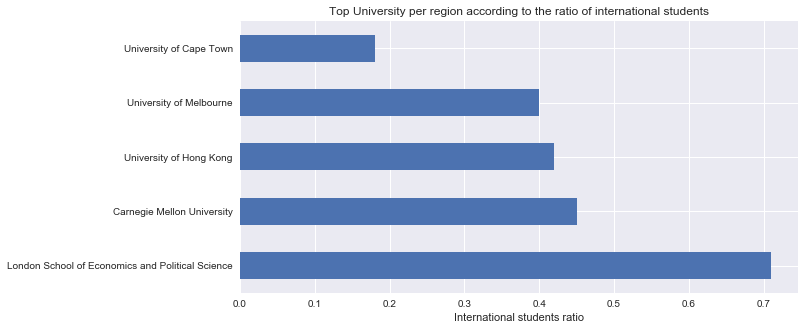

In [36]:
times_international_students_ratio_by_region_df = times_international_students_rank_df.groupby(COLUMN_REGION).head(1)
times_international_students_ratio_by_region_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10, 5))

plt.title('Top University per region according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

### Plot the results from Times ranking aggregating by country

For this question, we looked at the university with the best ratio in each country, for each of our defined ratios.

For the faculty members to total students ratio:

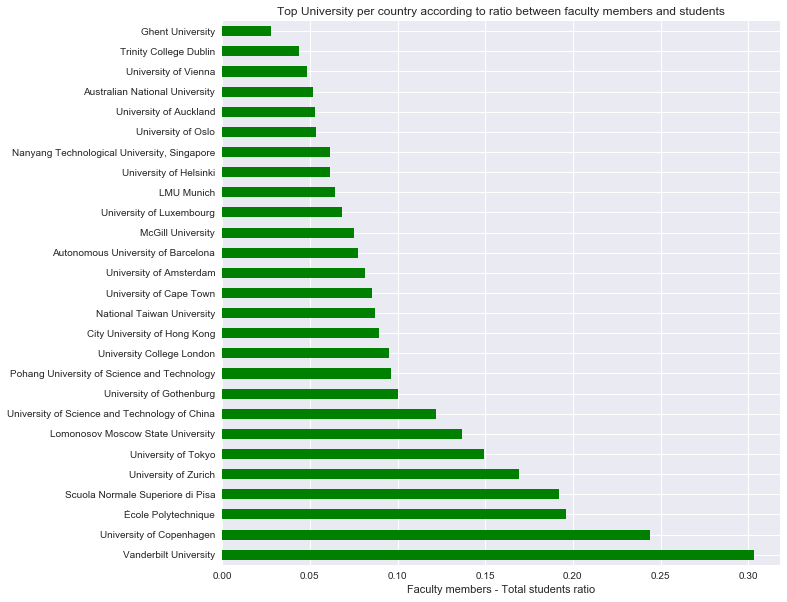

In [37]:
times_faculty_student_ratio_by_country_df = times_faculty_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
times_faculty_student_ratio_by_country_df[COLUMN_FACULTY_RATIO].plot(kind='barh', figsize=(10,10), color='green')

plt.title('Top University per country according to ratio between faculty members and students')
plt.ylabel("")
plt.xlabel('Faculty members - Total students ratio')
plt.show()

For the international to total student ratio:

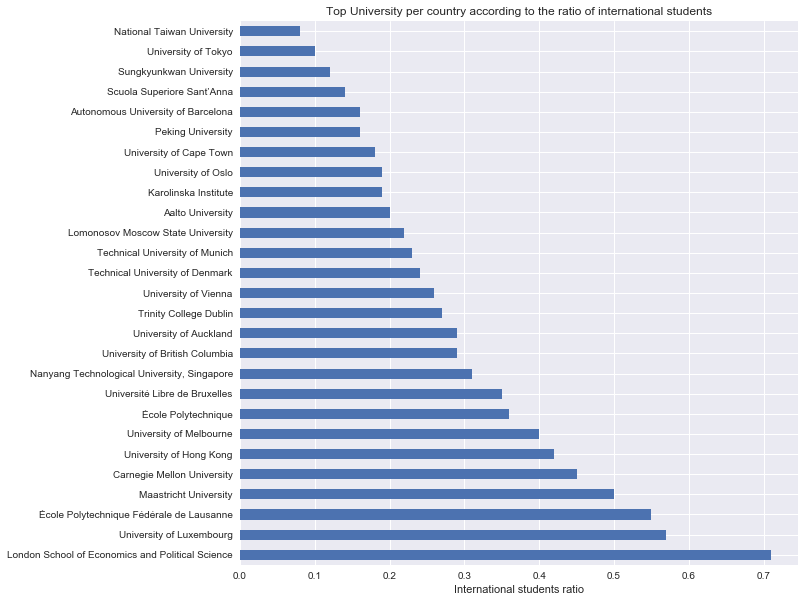

In [38]:
times_international_students_ratio_by_country_df = times_international_students_rank_df.groupby(COLUMN_COUNTRY).head(1)
times_international_students_ratio_by_country_df[COLUMN_INTERNATIONAL_RATIO].plot(kind='barh', figsize=(10, 10))

plt.title('Top University per country according to the ratio of international students')
plt.ylabel("")
plt.xlabel('International students ratio')
plt.show()

# Task 3 - Merge the dataframes
In this task we merge the two DataFrames created in tasks 1 and 2 using university names.

Merging is trivial because we have already handled the standardization of University Names during the scraping task. As explained previously, we looked up the name in the WikiData database to obtain the WikiData formatted entry (it is carried out using the function `search_standard_name`).

Therefore and since both rankings have names from the WikiData database, merging gives a perfect result. We first do some reorganization of the two dataframes as follows.

In [39]:
# Create column containing university name on which do the merging
qs_ranking_df[COLUMN_UNIVERSITY_NAME] = qs_ranking_df.index
times_ranking_df[COLUMN_UNIVERSITY_NAME] = times_ranking_df.index

In [40]:
# Clean up the values in QS ranking for perfect merge
qs_ranking_df[COLUMN_UNIVERSITY_NAME] = qs_ranking_df[COLUMN_UNIVERSITY_NAME].str.strip()
qs_ranking_df[COLUMN_COUNTRY] = qs_ranking_df[COLUMN_COUNTRY].str.strip()

# Clean up the values in Times ranking for perfect merge
times_ranking_df[COLUMN_UNIVERSITY_NAME] = times_ranking_df[COLUMN_UNIVERSITY_NAME].str.strip()
times_ranking_df[COLUMN_COUNTRY] = times_ranking_df[COLUMN_COUNTRY].str.strip()

Then we merge the two dataframes into one:

In [41]:
# Merge the dataframes via an outer join on the cols name, country and region
merged_ranking_df = pd.merge(qs_ranking_df, times_ranking_df, 
                             on=[COLUMN_UNIVERSITY_NAME, COLUMN_REGION, COLUMN_COUNTRY], 
                             how='outer', 
                             suffixes=('_QS', '_TM')
                            )

# Use the University Name as an index for the merged dataframe too
merged_ranking_df.set_index(COLUMN_UNIVERSITY_NAME, inplace=True)

merged_ranking_df.head()

,Country,Rank_QS,Region,Total Faculty_QS,Total International Faculty,Total International Students_QS,Total Students_QS,Total Faculty / Total Student_QS,Total International Students / Total Students_QS,Rank_TM,Total Faculty_TM,Total International Students_TM,Total Students_TM,Total Faculty / Total Student_TM,Total International Students / Total Students_TM
University Name,,,,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1.0,North America,2982.0,1679.0,3717.0,11067.0,0.269450,0.335863,5.0,1285.0,3800.0,11177.0,0.114968,0.339984
Stanford University,United States,2.0,North America,4285.0,2042.0,3611.0,15878.0,0.269870,0.227422,4.0,2113.0,3486.0,15845.0,0.133354,0.220006
Harvard University,United States,3.0,North America,4350.0,1311.0,5266.0,22429.0,0.193945,0.234785,6.0,2284.0,5285.0,20326.0,0.112368,0.260012
California Institute of Technology,United States,4.0,North America,953.0,350.0,647.0,2255.0,0.422616,0.286918,3.0,340.0,596.0,2209.0,0.153916,0.269805
University of Cambridge,United Kingdom,5.0,Europe,5490.0,2278.0,6699.0,18770.0,0.292488,0.356899,2.0,1687.0,6436.0,18389.0,0.091740,0.349992


The universities that appear in both rankings have some information repeated twice. These repeated values are different in many cases, although very similar. For the universities that only appear in one of the rankings, many of the values are missing.

We compute the mean for the repeated columns that contain information about the university - while still keeping track of the university position in each ranking. This also allows us to remove as many NaN values as possible, since the mean computation is ignoring the missing values.

In [42]:
# Replace -1 values for None values
merged_ranking_df.replace(-1, float('nan'), inplace=True)

cols = [COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_STUDENTS, COLUMN_TOTAL_FACULTY, 
        COLUMN_FACULTY_RATIO, COLUMN_INTERNATIONAL_RATIO]

for x in cols:
    merged_ranking_df[x] = merged_ranking_df[[x + '_QS', x + '_TM']].mean(axis=1)
    merged_ranking_df.drop([x + '_QS', x + '_TM'], axis=1, inplace=True)

Sample of the final result:

In [43]:
merged_ranking_df.head()

,Country,Rank_QS,Region,Total International Faculty,Rank_TM,Total Students,Total International Students,Total Faculty,Total Faculty / Total Student,Total International Students / Total Students
University Name,,,,,,,,,,
Massachusetts Institute of Technology,United States,1.0,North America,1679.0,5.0,11122.0,3758.5,2133.5,0.192209,0.337924
Stanford University,United States,2.0,North America,2042.0,4.0,15861.5,3548.5,3199.0,0.201612,0.223714
Harvard University,United States,3.0,North America,1311.0,6.0,21377.5,5275.5,3317.0,0.153157,0.247399
California Institute of Technology,United States,4.0,North America,350.0,3.0,2232.0,621.5,646.5,0.288266,0.278362
University of Cambridge,United Kingdom,5.0,Europe,2278.0,2.0,18579.5,6567.5,3588.5,0.192114,0.353446


## Task 4 - Exploratory analysis

It is interesting to see how the top universities are distributed among the continents. Nearly half of these top universities are in Europe, and around one fourth of them are in North America.

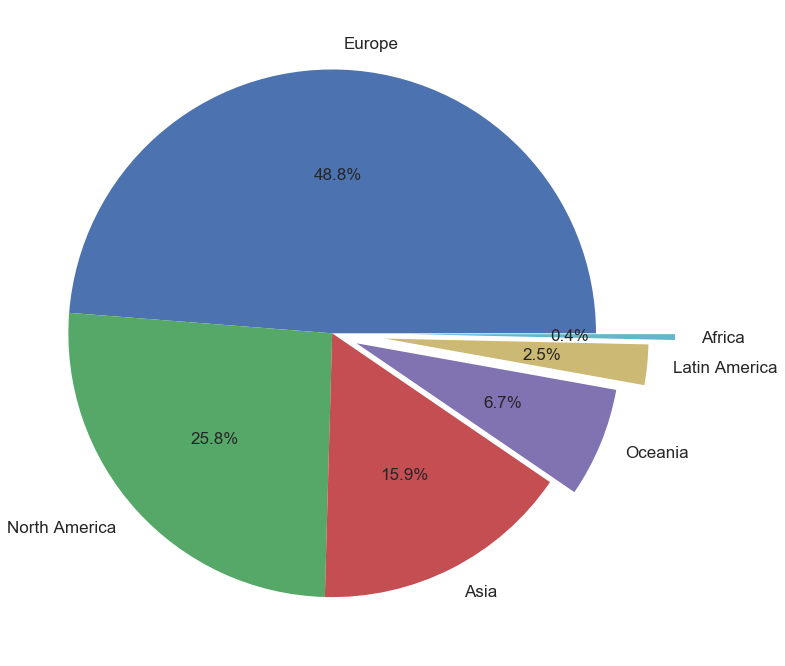

In [44]:
explode = (0, 0, 0, 0.1, 0.2, 0.3)
merged_ranking_df[COLUMN_REGION].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(12,12),fontsize=17, explode = explode)

plt.ylabel("")
plt.axis('equal')
plt.show()

We can then classify the universities according to their size. We are considering that their size is determined by the number of students, with the same classification that was used for the QS ranking (Described [here](http://www.iu.qs.com/university-rankings/qs-classifications/)).

In [45]:
def university_sizes(x):
    """Returns a size label based on the number of students."""
    if not x:
        return None
    else:
        return ('Small' if x < 5000 else 'Medium' if x < 12000
                else 'Large' if x < 30000 else 'Extra Large')

In [46]:
merged_ranking_df['Size'] = merged_ranking_df[COLUMN_TOTAL_STUDENTS].apply(lambda x: university_sizes(x))
merged_ranking_df.head()

,Country,Rank_QS,Region,Total International Faculty,Rank_TM,Total Students,Total International Students,Total Faculty,Total Faculty / Total Student,Total International Students / Total Students,Size
University Name,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1.0,North America,1679.0,5.0,11122.0,3758.5,2133.5,0.192209,0.337924,Medium
Stanford University,United States,2.0,North America,2042.0,4.0,15861.5,3548.5,3199.0,0.201612,0.223714,Large
Harvard University,United States,3.0,North America,1311.0,6.0,21377.5,5275.5,3317.0,0.153157,0.247399,Large
California Institute of Technology,United States,4.0,North America,350.0,3.0,2232.0,621.5,646.5,0.288266,0.278362,Small
University of Cambridge,United Kingdom,5.0,Europe,2278.0,2.0,18579.5,6567.5,3588.5,0.192114,0.353446,Large


When we look at the proportions of top universities according to their size, it is interesting to see that over 80% of them have more than 30,000 students - and out of these, 30% are considered to be extra large.

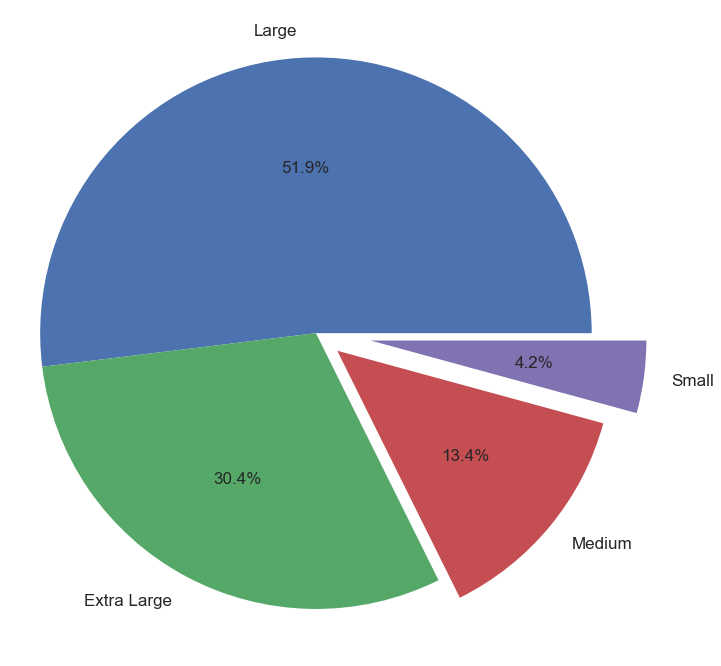

In [47]:
explode = (0, 0, 0.1, 0.2)
merged_ranking_df['Size'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(12,12), fontsize=17, explode = explode)

plt.ylabel("")
plt.axis('equal')
plt.show()

With the following boxplots we want to identify outliers within each region, and see if there is a difference in the ratio depending on the region of the university. 

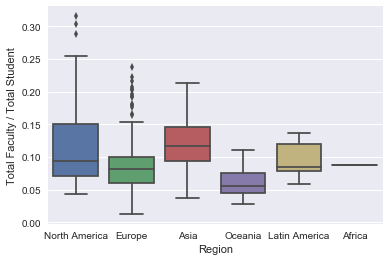

In [48]:
sns.boxplot(x=COLUMN_REGION, y=COLUMN_FACULTY_RATIO, data=merged_ranking_df)

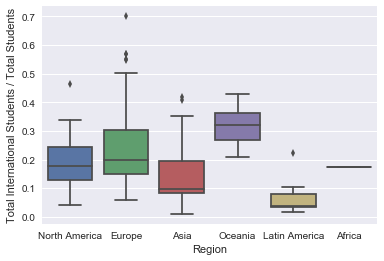

In [49]:
sns.boxplot(x=COLUMN_REGION, y=COLUMN_INTERNATIONAL_RATIO, data=merged_ranking_df);

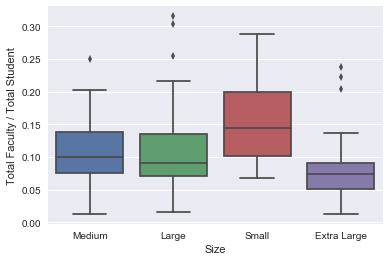

In [50]:
sns.boxplot(x='Size', y=COLUMN_FACULTY_RATIO, data=merged_ranking_df);

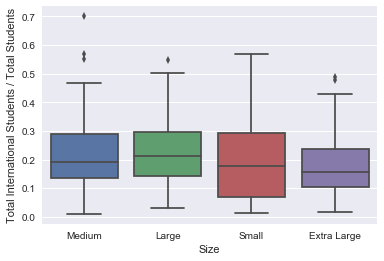

In [51]:
sns.boxplot(x='Size', y=COLUMN_INTERNATIONAL_RATIO, data=merged_ranking_df);

Now, we classify universities in three groups depending on their internationality ratio. We then plot different variables for all of these groups.

In [52]:
quantiles_int = merged_ranking_df[COLUMN_INTERNATIONAL_RATIO].max() / 3
merged_ranking_df['Internationality3'] = merged_ranking_df[COLUMN_INTERNATIONAL_RATIO].apply(lambda x: 'Not international' if x<quantiles_int else 'International' if x<quantiles_int * 2 else 'Very international')

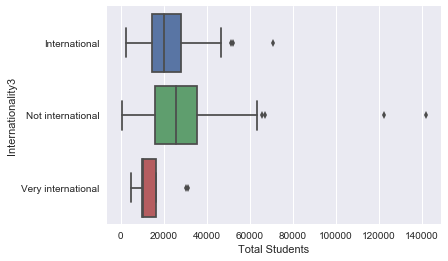

In [53]:
sns.boxplot(x=COLUMN_TOTAL_STUDENTS, y='Internationality3', data=merged_ranking_df);

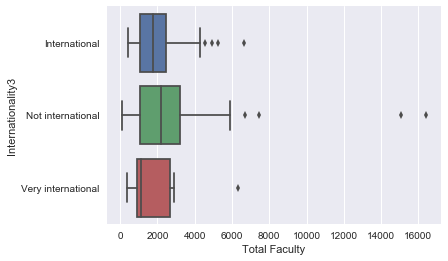

In [54]:
sns.boxplot(x=COLUMN_TOTAL_FACULTY, y='Internationality3', data=merged_ranking_df);

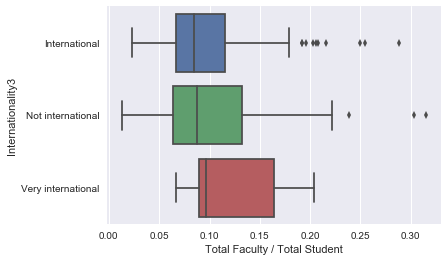

In [55]:
sns.boxplot(x=COLUMN_FACULTY_RATIO, y='Internationality3', data=merged_ranking_df);

#### TODO comment the above plots

    1. Why these plots?
    2. Which correlations we found?
    3. What are we missing?

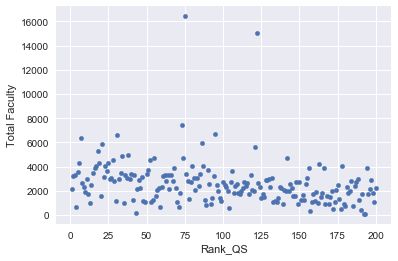

In [56]:
merged_ranking_df.plot(x=COLUMN_RANK + '_QS', y=COLUMN_TOTAL_FACULTY, kind='scatter')

Lastly, we obtain the correlation matrix for all the numeric variables. We also plot it for a better interpretation.

In [57]:
cols = ['{0}_QS'.format(COLUMN_RANK), '{0}_TM'.format(COLUMN_RANK), COLUMN_REGION,
        COLUMN_TOTAL_STUDENTS, COLUMN_INTERNATIONAL_STUDENTS, COLUMN_TOTAL_FACULTY,
        COLUMN_FACULTY_RATIO, COLUMN_INTERNATIONAL_RATIO]

merged_ranking_df[cols].corr()

,Rank_QS,Rank_TM,Total Students,Total International Students,Total Faculty,Total Faculty / Total Student,Total International Students / Total Students
Rank_QS,1.000000,0.731208,-0.042923,-0.322067,-0.266517,-0.357019,-0.366680
Rank_TM,0.731208,1.000000,-0.154720,-0.325885,-0.353415,-0.278616,-0.225795
Total Students,-0.042923,-0.154720,1.000000,0.559428,0.734180,-0.266081,-0.188185
Total International Students,-0.322067,-0.325885,0.559428,1.000000,0.404632,-0.196919,0.539103
Total Faculty,-0.266517,-0.353415,0.734180,0.404632,1.000000,0.357702,-0.120258
Total Faculty / Total Student,-0.357019,-0.278616,-0.266081,-0.196919,0.357702,1.000000,0.031720
Total International Students / Total Students,-0.366680,-0.225795,-0.188185,0.539103,-0.120258,0.031720,1.000000


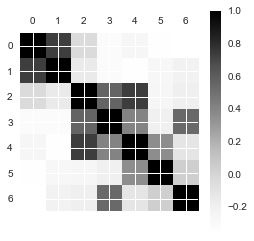

In [59]:
plt.matshow(merged_ranking_df[cols].corr())
plt.colorbar()

From the above plot we can see that there aren't any strong correlations, except for the two ranks, between the variables we are considering. Since there is no redundant information, we will use *all* of these variables for the ranking system we develop in task 5. 

## Task 5 - 